In [46]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np

In [47]:
df = pd.read_excel("online_retail_II-230817-120704.xlsx")

In [48]:
df = df.copy()

In [49]:
def check_data(dataframe, head=5):
    print ("####### SHAPE #######")
    print (dataframe.shape)
    print ("####### INFO #######")
    print (dataframe.info ())
    print ("####### DESCRIBE #######")
    print (dataframe.describe ([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print ("####### NA VALUES #######")
    print (dataframe.isnull ().sum ())
    print ("####### FIRST {} ROWS #######".format (head))
    print (dataframe.head (head))


In [50]:
def select_country(dataframe, country):
    new_dataframe = dataframe.loc[dataframe["Country"] == country]
    return new_dataframe

In [51]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [52]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds (dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any (axis=None):
        return True
    else:
        return False

In [53]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [54]:
check_data (df)

####### SHAPE #######
(525461, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
####### DESCRIBE #######
            Quantity          Price    Customer ID
count  525461.000000  525461.000000  417534.000000
mean       10.337667       4.688834   15360.645478
std       107.424110     146.126914    1680.811316
min     -9600.00000

In [55]:
df = df[~df["Invoice"].str.contains ("C", na=False)]

In [56]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [57]:
df = df[(df['Quantity'] > 0)]

In [58]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [59]:
df.dropna (inplace=True)

C:\Users\s7522\AppData\Local\Temp\ipykernel_9340\3830703625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna (inplace=True)


In [60]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [61]:
df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,Price,Customer ID
count,407695.000000,407695.000000,407695.000000
mean,13.586686,3.294188,15368.504107
std,96.842229,34.756655,1679.795700
min,1.000000,0.000000,12346.000000
1%,1.000000,0.290000,12435.000000
10%,1.000000,0.650000,13044.000000
25%,2.000000,1.250000,13997.000000
50%,5.000000,1.950000,15321.000000
75%,12.000000,3.750000,16812.000000
90%,24.000000,6.750000,17706.000000


In [62]:
df[df["Price"] == 0]["StockCode"].unique ()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [63]:
df = df[df["StockCode"] != "M"]

In [64]:
invalid_codes = df[df["StockCode"].astype (str).str.contains (r"[a-zA-Z]{3,}")]["StockCode"].unique ().tolist ()

In [65]:
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [66]:
df[df["StockCode"].isin (invalid_codes)].groupby (["StockCode"]).agg ({"Invoice": "nunique",
                                                                       "Quantity": "sum",
                                                                       "Price": "sum",
                                                                       "Customer ID": "nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.520,25
ADJUST2,3,3,731.050,3
BANK CHARGES,20,20,300.000,12
PADS,14,14,0.014,12
POST,738,2212,19964.830,230
TEST001,11,60,40.500,4
TEST002,1,1,1.000,1


In [67]:
df = df[~df["StockCode"].isin (invalid_codes)].reset_index (drop=True)

In [68]:
check_data (df)

####### SHAPE #######
(406450, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406450 entries, 0 to 406449
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406450 non-null  object        
 1   StockCode    406450 non-null  object        
 2   Description  406450 non-null  object        
 3   Quantity     406450 non-null  int64         
 4   InvoiceDate  406450 non-null  datetime64[ns]
 5   Price        406450 non-null  float64       
 6   Customer ID  406450 non-null  float64       
 7   Country      406450 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
####### DESCRIBE #######
            Quantity          Price    Customer ID
count  406450.000000  406450.000000  406450.000000
mean       13.616068       3.006186   15373.480736
std        96.987803       4.369193    1677.229818
min         1.00000

In [69]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [70]:
df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,Price,Customer ID,TotalPrice
count,406450.000000,406450.000000,406450.000000,406450.000000
mean,13.616068,3.006186,15373.480736,21.355409
std,96.987803,4.369193,1677.229818,69.139183
min,1.000000,0.000000,12346.000000,0.000000
1%,1.000000,0.290000,12437.000000,0.650000
10%,1.000000,0.650000,13050.000000,2.100000
25%,2.000000,1.250000,14006.000000,4.950000
50%,5.000000,1.950000,15325.000000,11.850000
75%,12.000000,3.750000,16814.000000,19.500000
90%,24.000000,6.750000,17706.000000,35.400000


In [71]:
max_invoice_date = df["InvoiceDate"].max ()

In [72]:
today_date = (max_invoice_date + dt.timedelta (days=2))

In [73]:
rfm = df.groupby ("Customer ID").agg ({"InvoiceDate": lambda date: (today_date - date.max ()).days,
                                       "Invoice": "nunique",
                                       "TotalPrice": "sum"})

In [74]:
rfm.head ()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,166,2,169.36
12347.0,4,2,1323.32
12348.0,75,1,221.16
12349.0,44,2,2221.14
12351.0,12,1,300.93


In [75]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

In [76]:
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [77]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Recency,Frequency,Monetary
count,4286.000000,4286.000000,4286.000000
mean,91.557863,4.426972,2025.176381
std,96.351299,7.946711,8829.908939
min,2.000000,1.000000,1.550000
1%,2.000000,1.000000,40.764000
10%,9.000000,1.000000,157.035000
25%,19.000000,1.000000,307.657500
50%,53.000000,2.000000,702.255000
75%,136.750000,5.000000,1703.985000
90%,255.000000,9.000000,3761.560000


In [78]:
for col in rfm.columns:
    print (col, check_outlier (rfm, col))

Recency False
Frequency True
Monetary True


In [79]:
for col in rfm.columns:
    replace_with_thresholds (rfm, col)
rfm.describe ()

,Recency,Frequency,Monetary
count,4286.000000,4286.000000,4286.000000
mean,91.557863,4.110826,1588.579193
std,96.351299,4.893364,2523.157048
min,2.000000,1.000000,1.550000
25%,19.000000,1.000000,307.657500
50%,53.000000,2.000000,702.255000
75%,136.750000,5.000000,1703.985000
max,375.000000,31.000000,15243.200000


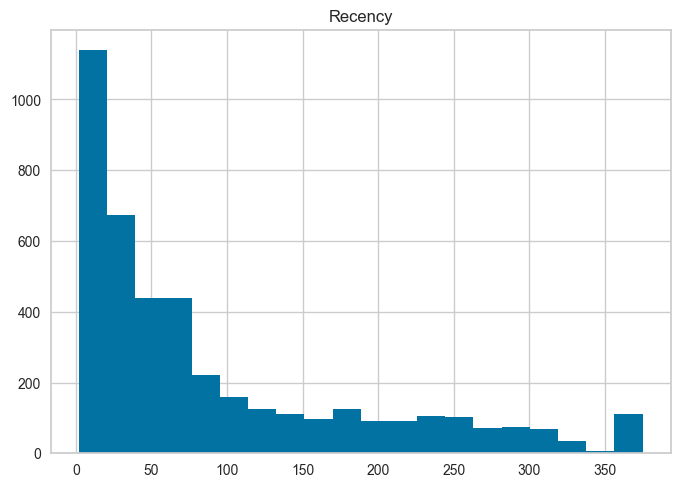

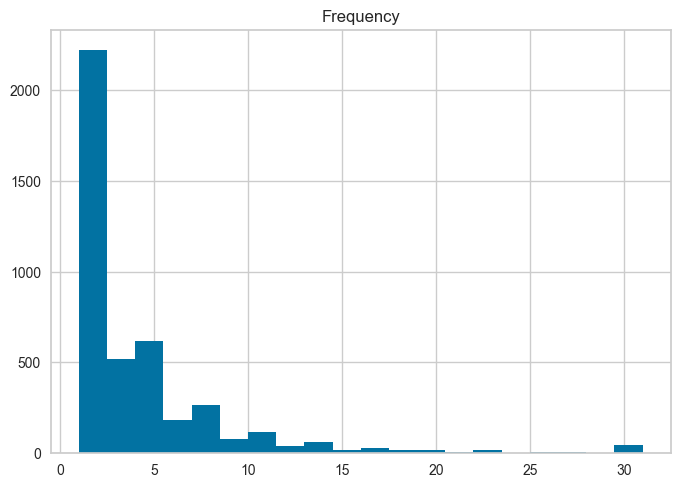

In [80]:
rfm["Recency"].hist (bins=20)
plt.title ("Recency")
plt.show ()

rfm["Frequency"].hist (bins=20)
plt.title ("Frequency")
plt.show ()

In [81]:
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p (rfm[col])
rfm.head ()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.0,166.0,2,169.36,5.117994,1.098612
12347.0,4.0,2,1323.32,1.609438,1.098612
12348.0,75.0,1,221.16,4.330733,0.693147
12349.0,44.0,2,2221.14,3.806662,1.098612
12351.0,12.0,1,300.93,2.564949,0.693147


In [82]:
sc = StandardScaler ()
sc.fit (rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform (rfm[["LOG_Recency", "LOG_Frequency"]])

scaled_df = pd.DataFrame (index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.0,0.986476,-0.396575
12347.0,-1.850271,-0.396575
12348.0,0.349958,-1.004394
12349.0,-0.073765,-0.396575
12351.0,-1.077718,-1.004394
...,...,...
18283.0,-0.729420,0.873581
18284.0,0.271833,-1.004394
18285.0,1.454691,-1.004394


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

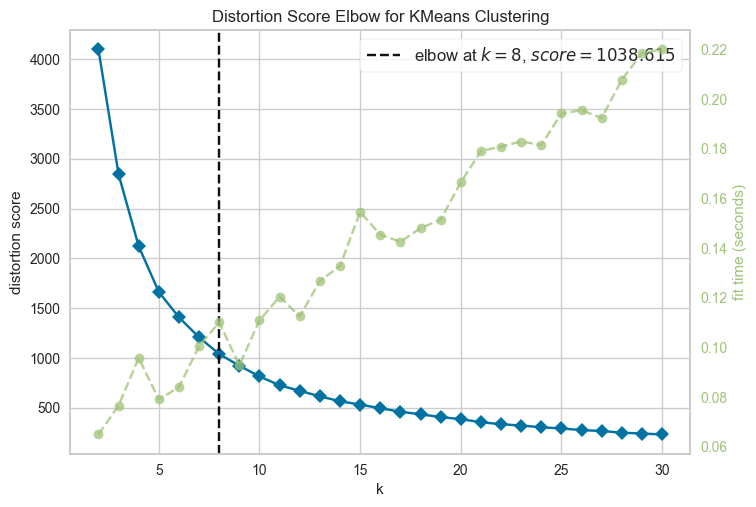

8


In [83]:
kmeans = KMeans ()
elbow = KElbowVisualizer (kmeans, k=30)
elbow.fit (scaled_df)
elbow.show ()

k_ = elbow.elbow_value_

print (k_)

In [97]:
k_means = KMeans (n_clusters=k_, random_state=99).fit (scaled_df)
segments = k_means.labels_

rfm["KMeans_Segments"] = segments
rfm.head ()

c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments,Hierarchi_Segments
Customer ID,,,,,,,
12346.0,166.0,2,169.36,5.117994,1.098612,1,2
12347.0,4.0,2,1323.32,1.609438,1.098612,0,3
12348.0,75.0,1,221.16,4.330733,0.693147,2,4
12349.0,44.0,2,2221.14,3.806662,1.098612,2,1
12351.0,12.0,1,300.93,2.564949,0.693147,6,3


In [98]:
rfm.groupby ("KMeans_Segments").agg ({"Recency": ["mean", "median", "count"],
                                      "Frequency": ["mean", "median", "count"],
                                      "Monetary": ["mean", "median", "count"]})

Recency               Frequency                  Monetary  \
                       mean median count       mean median count         mean   
KMeans_Segments                                                                 
0                  6.392045    5.0   352   5.227273    5.0   352  1896.924858   
1                241.969116  234.0   939   1.242812    1.0   939   403.232886   
2                 69.273418   66.0   790   1.434177    1.0   790   533.500962   
3                 32.645833   25.0   384  10.401042    9.0   384  4145.364609   
4                  6.018692    5.0   214  19.233645   17.0   214  7843.345981   
5                118.366782   96.0   578   4.166090    4.0   578  1667.545882   
6                 20.109705   20.0   474   1.472574    1.0   474   506.442110   
7                 29.657658   29.0   555   4.077477    4.0   555  1561.514054   

                                 
                   median count  
KMeans_Segments                  
0                1382.805   352  
1                 266.500   939  
2                 378.460   790  
3                3148.775   384  
4                6008.610   214  
5                1234.720   578  
6                 350.015   474  
7                1189.380   555

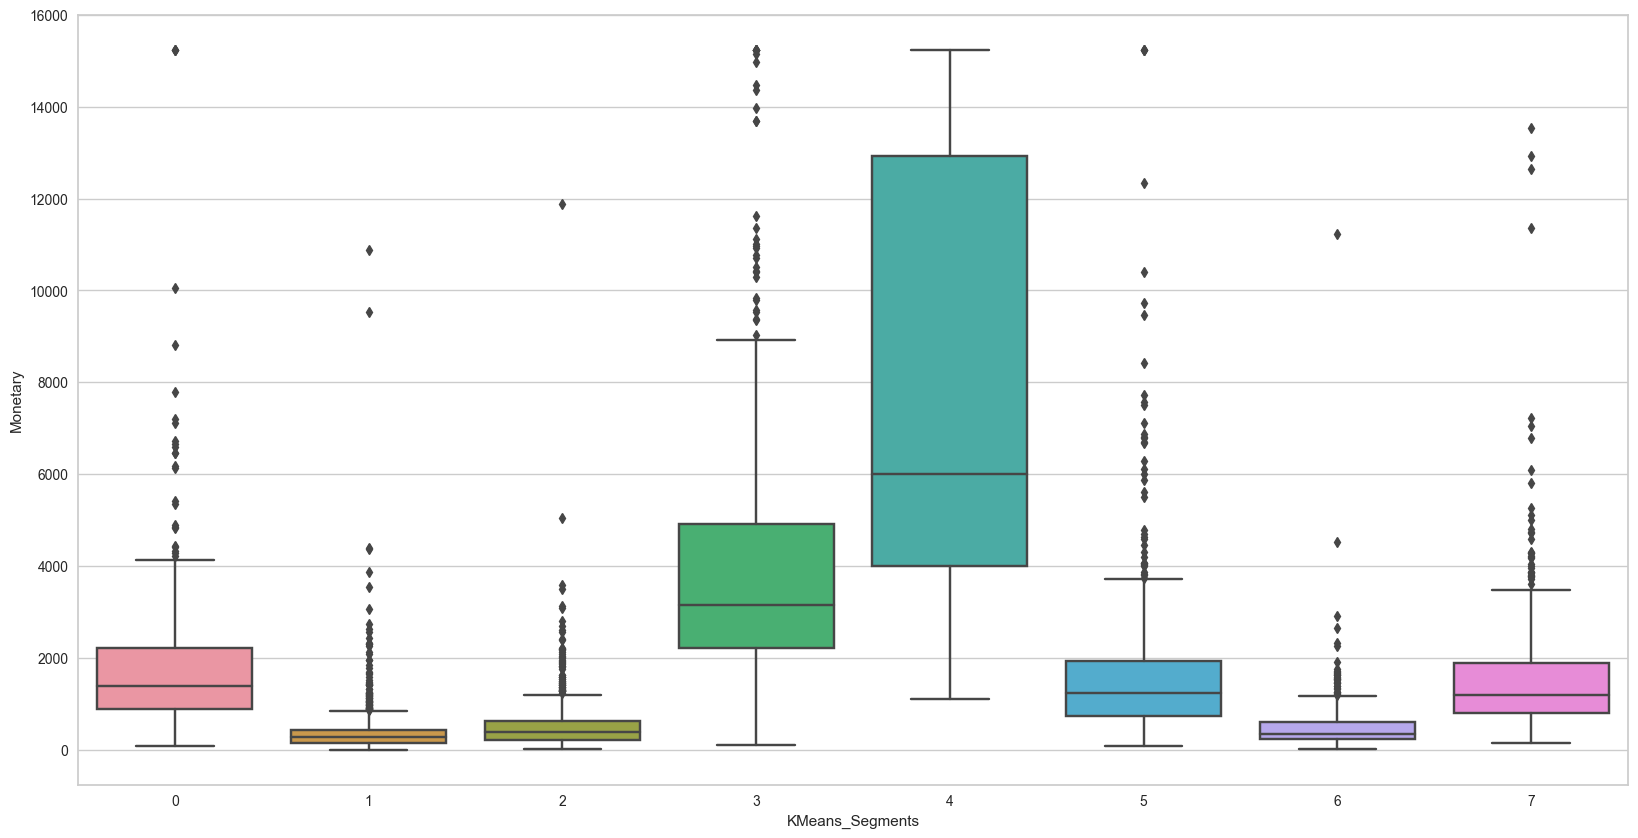

In [95]:
plt.figure (figsize=(20, 10))
sns.boxplot (x="KMeans_Segments", y="Monetary", data=rfm)
plt.show ()

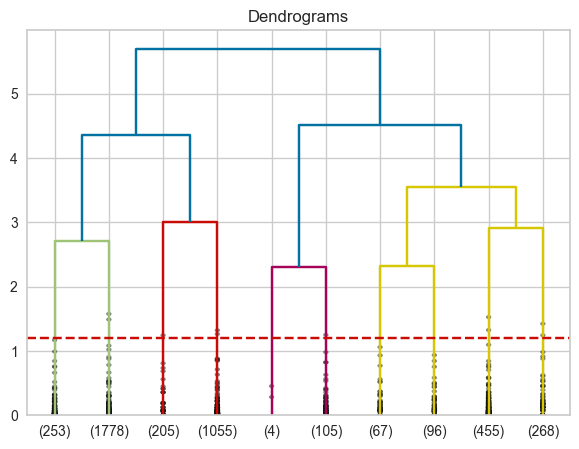

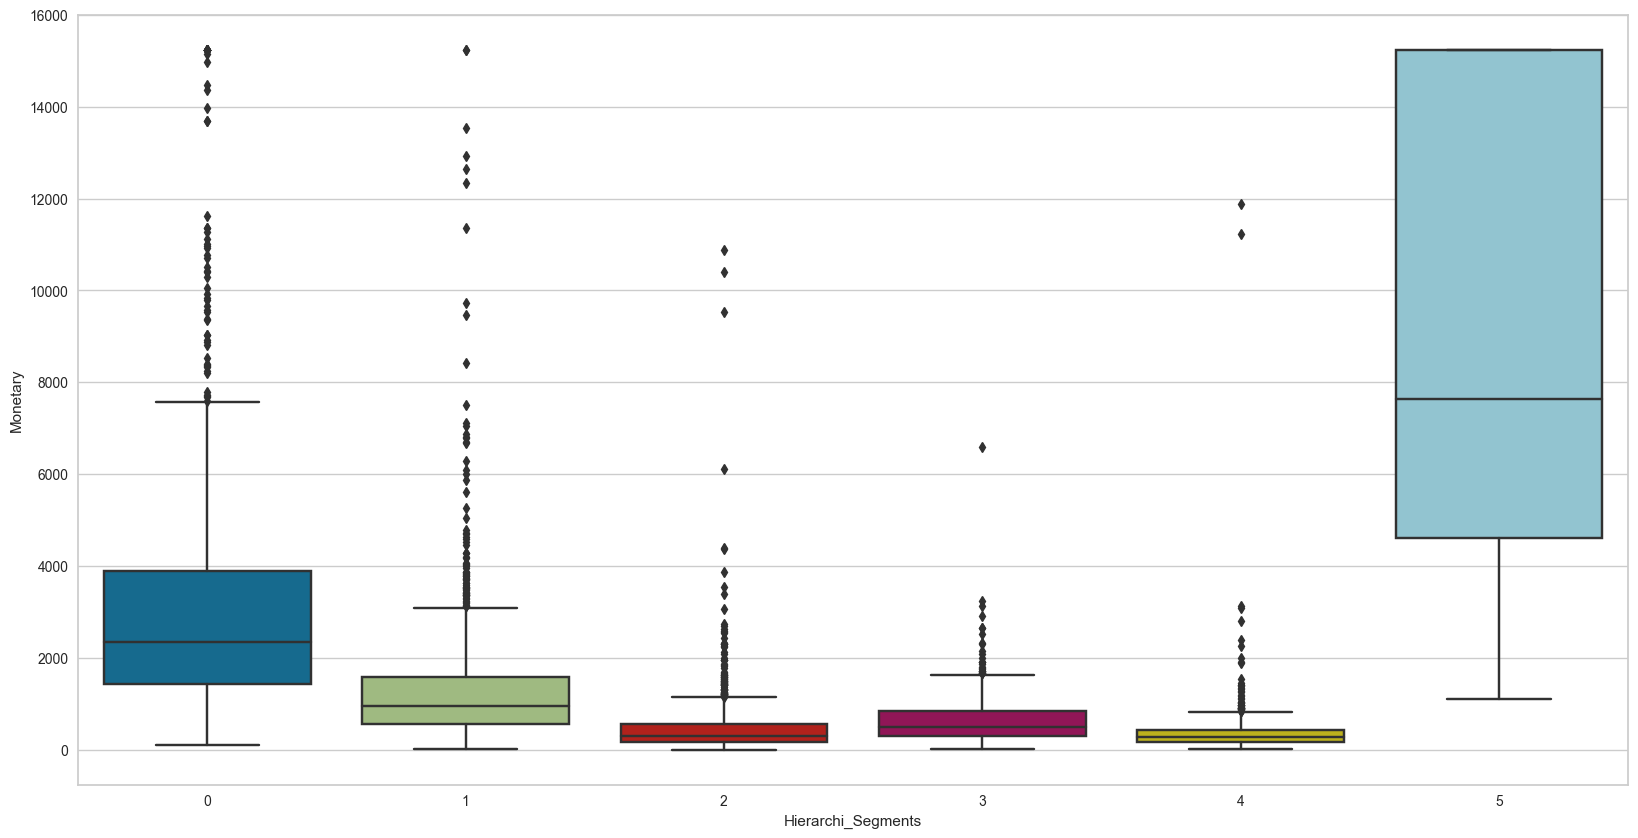

In [86]:
hc_complete = linkage (scaled_df, 'complete')

plt.figure (figsize=(7, 5))
plt.title ("Dendrograms")
dend = dendrogram (hc_complete,
                   truncate_mode="lastp",
                   p=10,
                   show_contracted=True,
                   leaf_font_size=10)
plt.axhline (y=1.2, color='r', linestyle='--')
plt.show ()

hc = AgglomerativeClustering (n_clusters=6)
segments = hc.fit_predict (scaled_df)
rfm["Hierarchi_Segments"] = segments
rfm.groupby ("Hierarchi_Segments").agg ({"Recency": ["mean", "median", "count"],
                                         "Frequency": ["mean", "median", "count"],
                                         "Monetary": ["mean", "median", "count"]})


plt.figure (figsize=(20, 10))
sns.boxplot (x="Hierarchi_Segments", y="Monetary", data=rfm)
plt.show ()
